## PARTIE 0 : récupération, préparation et Fusion des Datasets ##

L'analyse multivariée repose sur l'intégration de variables exogènes (externes) pour améliorer la précision prédictive. Ici, nous fusionnons les données de consommation électrique avec les données météorologiques.

    Alignement temporel : Synchronisation des deux sources sur un index commun via une jointure interne (inner merge).

  

In [1]:
import requests
import pandas as pd
import time

def fetch_brest_electricity_data():
    base_url = "https://odre.opendatasoft.com/api/explore/v2.1/catalog/datasets/eco2mix-metropoles-tr/exports/json"
    
    # Paramètres de la requête
    params = {
        "where": "libelle_metropole='Brest Métropole' AND date_heure >= '2020-01-01' AND date_heure <= '2025-12-31'",
        "order_by": "date_heure ASC",
        "timezone": "UTC"
    }
    
    print("Récupération des données pour Brest Métropole (2020-2025)...")
    
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        
        data = response.json()
        df = pd.DataFrame(data)
        print(df.head())
        # Nettoyage de base
        df['date_heure'] = pd.to_datetime(df['date_heure'])
        # On garde l'essentiel : temps et consommation (puissance en MW)
        df = df[['date_heure', 'consommation']].dropna()
        
        print(f"Chargement Terminé ! {len(df)} lignes récupérées.")
        return df

    except Exception as e:
        print(f"❌ Erreur lors de la récupération : {e}")
        return None

# Exécution
df_conso_brest = fetch_brest_electricity_data()

if df_conso_brest is not None:
    print(df_conso_brest.head())
    # Sauvegarde pour l'atelier
    df_conso_brest.to_csv("conso_brest_2020_2025.csv", index=False)

Récupération des données pour Brest Métropole (2020-2025)...
  code_insee_epci libelle_metropole              nature        date heures  \
0       242900314   Brest Métropole  Données temps réel  2020-01-01  01:00   
1       242900314   Brest Métropole  Données temps réel  2020-01-01  01:15   
2       242900314   Brest Métropole  Données temps réel  2020-01-01  01:30   
3       242900314   Brest Métropole  Données temps réel  2020-01-01  01:45   
4       242900314   Brest Métropole  Données temps réel  2020-01-01  02:00   

                  date_heure  consommation production echanges_physiques  
0  2020-01-01T00:00:00+00:00         106.0       None               None  
1  2020-01-01T00:15:00+00:00         108.0       None               None  
2  2020-01-01T00:30:00+00:00         113.0       None               None  
3  2020-01-01T00:45:00+00:00         121.0       None               None  
4  2020-01-01T01:00:00+00:00         119.0       None               None  
Chargement Terminé !

In [2]:
import pandas as pd
import matplotlib.pyplot as plt




# 1. indexation temporelle
df_conso_brest = df_conso_brest.rename(columns={"date_heure": "date"})
df_conso_brest['date'] = pd.to_datetime(df_conso_brest['date'], utc=True)
df_conso_brest = df_conso_brest.set_index('date').sort_index()

# changement de temporalité des données
df_conso_brest_journ = df_conso_brest['consommation'].resample('D').mean().interpolate()

# Définition des périodes pour les jeux d'apprentissage
#dataset_train = df_daily['2015-01-01':'2024-12-31']
#dataset_test = df_daily['2025-01-01':'2025-12-31']


In [3]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Configuration de l'API avec cache et relance automatique en cas d'erreur
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

def get_weather_data_brest(start_date, end_date):
    url = "https://archive-api.open-meteo.com/v1/archive"
    
    params = {
        "latitude": 48.3904, # Brest
        "longitude": -4.4861,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": ["temperature_2m", "relative_humidity_2m", "wind_speed_10m", "shortwave_radiation"],
        "timezone": "Europe/Berlin"
    }
    
    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]

    # Processus de transformation des données horaires
    hourly = response.Hourly()
    hourly_data = {"date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    )}
    
    hourly_data["temp_moy"] = hourly.Variables(0).ValuesAsNumpy()
    hourly_data["humidity"] = hourly.Variables(1).ValuesAsNumpy()
    hourly_data["vent_vitesse"] = hourly.Variables(2).ValuesAsNumpy()
    hourly_data["rayonnement_moyen"] = hourly.Variables(3).ValuesAsNumpy()

    df_meteo = pd.DataFrame(data=hourly_data)
    
    # Passage en format journalier (moyenne) pour correspondre à vos données de conso
    df_meteo_journ = df_meteo.resample('D', on='date').mean()
    
    return df_meteo_journ

# Exemple d'utilisation (ajustez les dates selon votre historique de consommation)
df_meteo_brest_journ = get_weather_data_brest("2020-01-01", "2025-12-31")
print(df_meteo_brest_journ.head())

                            temp_moy   humidity  vent_vitesse  \
date                                                            
2019-12-31 00:00:00+00:00  10.150000  97.032616      9.470120   
2020-01-01 00:00:00+00:00   9.158334  96.470070      6.283340   
2020-01-02 00:00:00+00:00  10.312500  91.239723     22.854681   
2020-01-03 00:00:00+00:00   9.056251  85.719337     18.014933   
2020-01-04 00:00:00+00:00   7.085417  81.455223      6.970688   

                           rayonnement_moyen  
date                                          
2019-12-31 00:00:00+00:00           0.000000  
2020-01-01 00:00:00+00:00          30.083334  
2020-01-02 00:00:00+00:00          27.291666  
2020-01-03 00:00:00+00:00          20.166666  
2020-01-04 00:00:00+00:00          40.958332  


In [4]:
# 2. Fusion (Jointure sur la date)
# 1. Conversion forcée au format datetime pour les deux DataFrames
# On s'assure que les deux sont en UTC pour éviter les décalages d'heures

#df_meteo.index = pd.to_datetime(df_meteo.index, utc=True) # Si la date est en index dans df_meteo


df_data_multi_brest = pd.merge(df_conso_brest_journ, df_meteo_brest_journ, on='date', how='inner')

print(df_data_multi_brest.head())



                           consommation   temp_moy   humidity  vent_vitesse  \
date                                                                          
2020-01-01 00:00:00+00:00    110.031579   9.158334  96.470070      6.283340   
2020-01-02 00:00:00+00:00    127.781250  10.312500  91.239723     22.854681   
2020-01-03 00:00:00+00:00    130.812500   9.056251  85.719337     18.014933   
2020-01-04 00:00:00+00:00    129.583333   7.085417  81.455223      6.970688   
2020-01-05 00:00:00+00:00    127.906250   7.362500  83.211845     11.346040   

                           rayonnement_moyen  
date                                          
2020-01-01 00:00:00+00:00          30.083334  
2020-01-02 00:00:00+00:00          27.291666  
2020-01-03 00:00:00+00:00          20.166666  
2020-01-04 00:00:00+00:00          40.958332  
2020-01-05 00:00:00+00:00          31.833334  


## PARTIE 1 : Ingénierie des caractéristiques ##

Nous allons aider le modèle en construisant des caractéristiques reflétant la position du chargé de prédiction le jour j.


In [5]:

# --- PASSÉ (Lags) ---
# Consommation de la veille (J-1) et de la semaine dernière (J-7) pour la saisonnalité
df_data_multi_brest['conso_obs_j-1'] = df_data_multi_brest['consommation'].shift(1)
df_data_multi_brest['conso_obs_j-2'] = df_data_multi_brest['consommation'].shift(2)
df_data_multi_brest['conso_obs_j-7'] = df_data_multi_brest['consommation'].shift(7)

# Météo observée hier (J-1) pour l'inertie thermique
df_data_multi_brest['temp_obs_j-1'] = df_data_multi_brest['temp_moy'].shift(1)

# Météo observée hier (J-1) pour l'humidité
df_data_multi_brest['humidity_j-1'] = df_data_multi_brest['humidity'].shift(1)

# Météo observée hier (J-1) pour le rayonnement
df_data_multi_brest['rayonnement_moyen_j-1'] = df_data_multi_brest['rayonnement_moyen'].shift(1)

# Météo observée hier (J-1) pour le vent
df_data_multi_brest['vent_vitesse_j-1'] = df_data_multi_brest['vent_vitesse'].shift(1)

# --- FUTUR / PRÉVISIONS (Leads) ---
# On utilise la donnée réelle de J comme si c'était la prévision faite le matin même
df_data_multi_brest['temp_prev_j'] = df_data_multi_brest['temp_moy'] 

# On utilise la donnée de J+1 comme prévision pour demain (Lead)
df_data_multi_brest['temp_prev_j+1'] = df_data_multi_brest['temp_moy'].shift(-1)

# Nettoyage des lignes avec des NaN créés par les décalages
df_data_multi_brest = df_data_multi_brest.dropna()

print(df_data_multi_brest.head())


# Définition des périodes
dataset_train = df_data_multi_brest['2015-01-01':'2024-12-31']
dataset_test = df_data_multi_brest['2025-01-01':'2025-12-31']




                           consommation   temp_moy   humidity  vent_vitesse  \
date                                                                          
2020-01-08 00:00:00+00:00    137.083333  11.452084  98.143959     19.064034   
2020-01-09 00:00:00+00:00    138.270833  10.443749  89.135468     29.175734   
2020-01-10 00:00:00+00:00    139.572917   8.733334  73.938469     15.507682   
2020-01-11 00:00:00+00:00    127.395833  10.325000  77.339989     26.753418   
2020-01-12 00:00:00+00:00    112.239583  10.360416  78.950714     21.793165   

                           rayonnement_moyen  conso_obs_j-1  conso_obs_j-2  \
date                                                                         
2020-01-08 00:00:00+00:00           9.083333     144.520833     153.281250   
2020-01-09 00:00:00+00:00          31.333334     137.083333     144.520833   
2020-01-10 00:00:00+00:00          50.958332     138.270833     137.083333   
2020-01-11 00:00:00+00:00          36.750000     139.572

In [6]:
import holidays

# On définit les jours fériés en France 
fr_holidays = holidays.France()

def add_calendar_features(df):
    # On travaille sur une copie pour ne pas modifier l'original par mégarde
    df_enriched = df.copy()
    
    # 1. Variables temporelles basiques
    df_enriched['day_of_week'] = df_enriched.index.dayofweek
    df_enriched['month'] = df_enriched.index.month
    df_enriched['is_weekend'] = df_enriched.index.dayofweek.isin([5, 6]).astype(int)
    
    # 2. Jours fériés (Boolean : 1 si férié, 0 sinon)
    df_enriched['is_holiday'] = df_enriched.index.map(lambda x: 1 if x in fr_holidays else 0)
    
    # 3. Optionnel : Veille et Lendemain de jour férié (souvent utile pour les ponts)
    df_enriched['is_holiday_prev'] = df_enriched['is_holiday'].shift(-1, fill_value=0)
    df_enriched['is_holiday_next'] = df_enriched['is_holiday'].shift(1, fill_value=0)
    
    return df_enriched

# Application sur vos datasets
dataset_train_enriched = add_calendar_features(dataset_train)
dataset_test_enriched = add_calendar_features(dataset_test)

print(dataset_test_enriched.head())

                           consommation   temp_moy   humidity  vent_vitesse  \
date                                                                          
2025-01-01 00:00:00+00:00    105.604167  11.152083  88.827751     32.306896   
2025-01-02 00:00:00+00:00    126.947917   6.970833  85.181351      8.452300   
2025-01-03 00:00:00+00:00    140.791667   3.875000  74.935020     13.577527   
2025-01-04 00:00:00+00:00    144.927083   5.814583  89.105927     23.348068   
2025-01-05 00:00:00+00:00    113.427083  12.947917  93.039711     39.424568   

                           rayonnement_moyen  conso_obs_j-1  conso_obs_j-2  \
date                                                                         
2025-01-01 00:00:00+00:00          24.125000     125.208333     130.020833   
2025-01-02 00:00:00+00:00          21.000000     105.604167     125.208333   
2025-01-03 00:00:00+00:00          57.416668     126.947917     105.604167   
2025-01-04 00:00:00+00:00          10.125000     140.791

In [7]:
from sklearn.ensemble import IsolationForest
import pandas as pd

# 1. Nettoyage des données
# On retire les lignes avec des NaNs (créés par les variables de lag j-1, j-7, etc.)
train_clean = dataset_train_enriched.dropna()
test_clean = dataset_test_enriched.dropna()

# 2. Initialisation du modèle
# contamination : proportion estimée d'anomalies (ex: 0.01 pour 1%)
model_if = IsolationForest(n_estimators=100, 
                           contamination=0.01, 
                           random_state=42)

# 3. Entraînement
# On entraîne sur toutes les variables (conso + météo + calendrier)
model_if.fit(train_clean)

# 4. Détection
# /!\ IMPORTANT : On calcule d'abord les résultats pour ne pas modifier 
# le nombre de colonnes de test_clean pendant les appels au modèle.
scores = model_if.decision_function(test_clean)
predictions = model_if.predict(test_clean)

# Maintenant, on peut ajouter les résultats comme nouvelles colonnes
test_clean['anomaly_score'] = scores
test_clean['is_anomaly'] = predictions

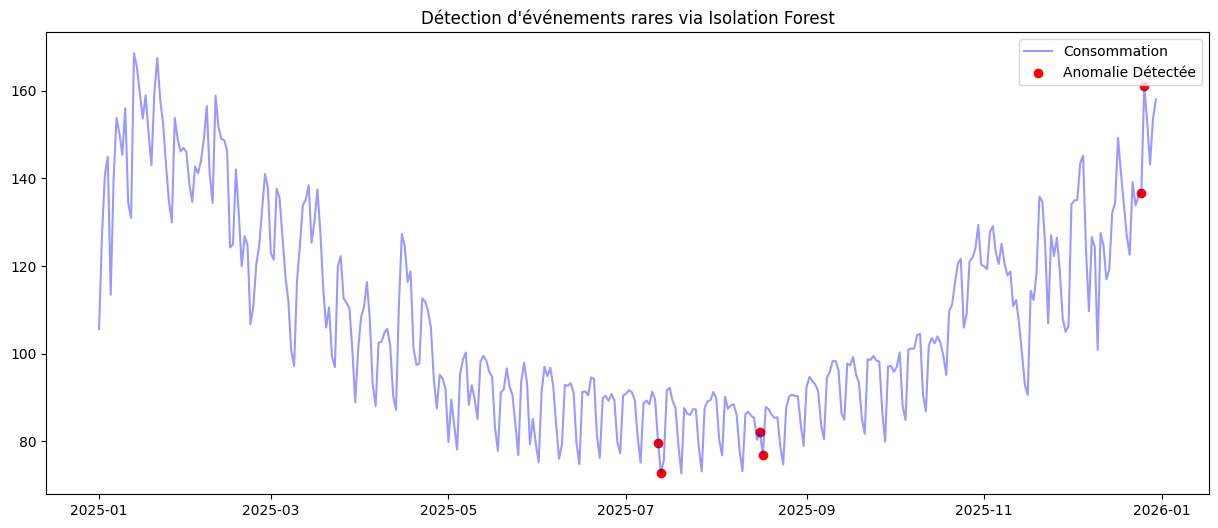

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
# Tracer la consommation réelle
plt.plot(test_clean.index, test_clean['consommation'], color='blue', alpha=0.4, label='Consommation')

# Identifier les anomalies
anomalies = test_clean[test_clean['is_anomaly'] == -1]

# Superposer les points rouges
plt.scatter(anomalies.index, anomalies['consommation'], color='red', label='Anomalie Détectée')

plt.title('Détection d\'événements rares via Isolation Forest')
plt.legend()
plt.show()

2 sujets d'intérêt :

1 : Pourquoi le point est considéré comme une anomalie (en gardant les scores abstraits du modèle Isolation Forest) ?

2 : Pourquoi la consommation a atteint cette valeur précise en MW (ce qui nécessite d'utiliser un autre modèle, de type régression) ?


1. Changement de perspective : Cause vs Rareté

    Avec l'Isolation Forest (Option 1) : Vous expliquez pourquoi la situation est rare. (Exemple : "Ce point est facile à isoler car il n'arrive jamais d'avoir 120 MW de consommation un dimanche par 25°C"). On explique l'atypisme.

    Avec un modèle de régression (Option 2) : Vous expliquez le volume. (Exemple : "La consommation atteint 120 MW parce qu'il fait 25°C [+15 MW] et que nous sommes en semaine de forte activité [+40 MW]"). On explique les moteurs de la demande.

2. L'anomalie vue par la régression : Le Résidu

Pour détecter une anomalie avec un modèle de régression (comme votre LSTM), on regarde l'écart entre la prédiction et la réalité (le résidu).

L'explication SHAP sur la régression vous donne la raison de l'anomalie de manière indirecte mais très parlante :

    Le graphique SHAP vous montre ce que le modèle considère comme "normal" pour ce jour-là (la valeur prédite, décomposée en MW).

    Si la réalité est très différente, l'explication de l'anomalie devient : "Le modèle prédisait 90 MW à cause de la météo douce, mais on observe 140 MW. L'anomalie est donc l'écart de 50 MW que les variables exogènes actuelles (météo, calendrier) n'expliquent pas."

3. Les avantages de cette 2ème approche

    Unité concrète : On parle en MW. C'est beaucoup plus facile à présenter à des non-experts que des scores de "profondeur d'isolation".

    Identification des variables "Normalisantes" : Vous verrez quelles variables essayaient de maintenir la prévision à un niveau bas, ce qui souligne par contraste la puissance de l'événement imprévu.

En résumé : L'Isolation Forest dit "C'est bizarre à cause de la combinaison de X et Y", alors que la Régression dit "D'après X et Y, on devrait être à 100 MW, donc les 150 MW observés sont injustifiés".

## Etape 1 d'explicabilité : Montrer pourquoi une anomalie est une anomalie ##

c:\Code_ML\Code\Atelier Time Series\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                           consommation   temp_moy   humidity  vent_vitesse  \
date                                                                          
2025-07-12 00:00:00+00:00     79.750000  25.295832  49.243259     13.885876   
2025-07-13 00:00:00+00:00     72.739583  20.837500  68.758308     12.283070   
2025-08-16 00:00:00+00:00     82.125000  25.466667  57.088638     17.227064   
2025-08-17 00:00:00+00:00     76.822917  23.125000  66.095428     11.251966   
2025-12-25 00:00:00+00:00    136.760417   2.433333  73.914337     20.733814   
2025-12-26 00:00:00+00:00    160.968750   2.468750  84.214142     17.794146   

                           rayonnement_moyen  conso_obs_j-1  conso_obs_j-2  \
date                                                                         
2025-07-12 00:00:00+00:00         329.875000      89.583333      91.322917   
2025-07-13 00:00:00+00:00         248.291672      79.750000      89.583333   
2025-08-16 00:00:00+00:00         264.291656      80.38

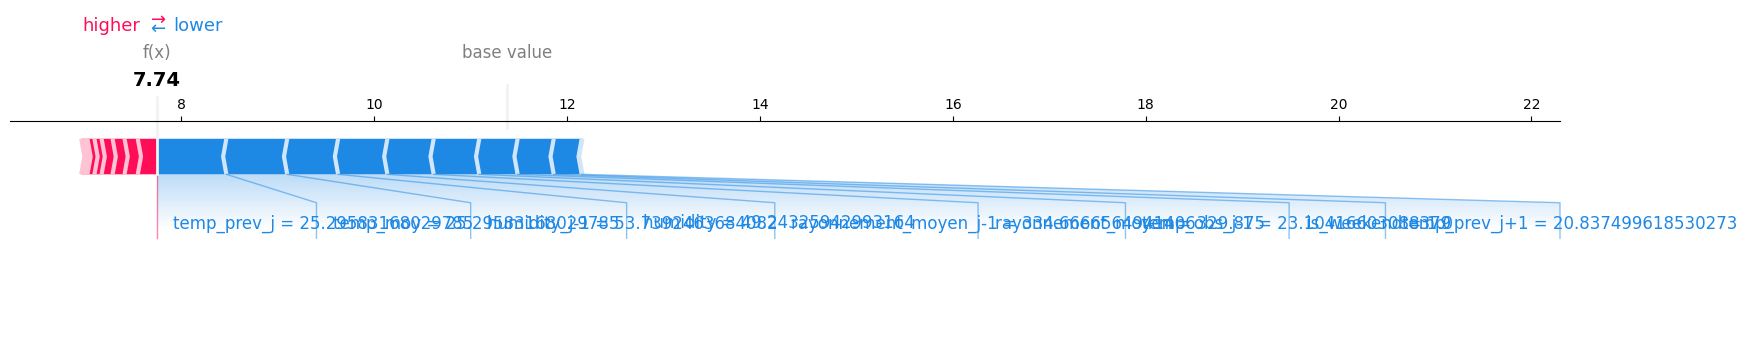

In [ ]:
import shap
import numpy as np

# On s'assure que les données passées à SHAP sont des valeurs pures (numpy) 
# pour éviter les conflits de noms de colonnes ou d'index de Pandas
features_cols = train_clean.columns.tolist()
X_reference = train_clean[features_cols].values
X_anomaly = test_clean[test_clean['is_anomaly'] == -1][features_cols].values

print("liste des anomalies détectées")
print(test_clean[test_clean['is_anomaly'] == -1][features_cols])

# 1. Initialisation de l'explainer avec le modèle déjà entraîné
# On utilise un échantillon du train pour la baseline
explainer = shap.TreeExplainer(model_if, data=X_reference[:100])

# 2. Calcul des SHAP values pour la première anomalie détectée
# On prend l'index 0 de notre tableau d'anomalies
shap_values_single = explainer.shap_values(X_anomaly[0:1])

# 3. Visualisation
# Comme c'est du numpy, on repasse les noms de colonnes pour la lisibilité
shap.force_plot(
    explainer.expected_value, 
    shap_values_single[0], 
    features=X_anomaly[0:1], 
    feature_names=features_cols,
    matplotlib=True
)



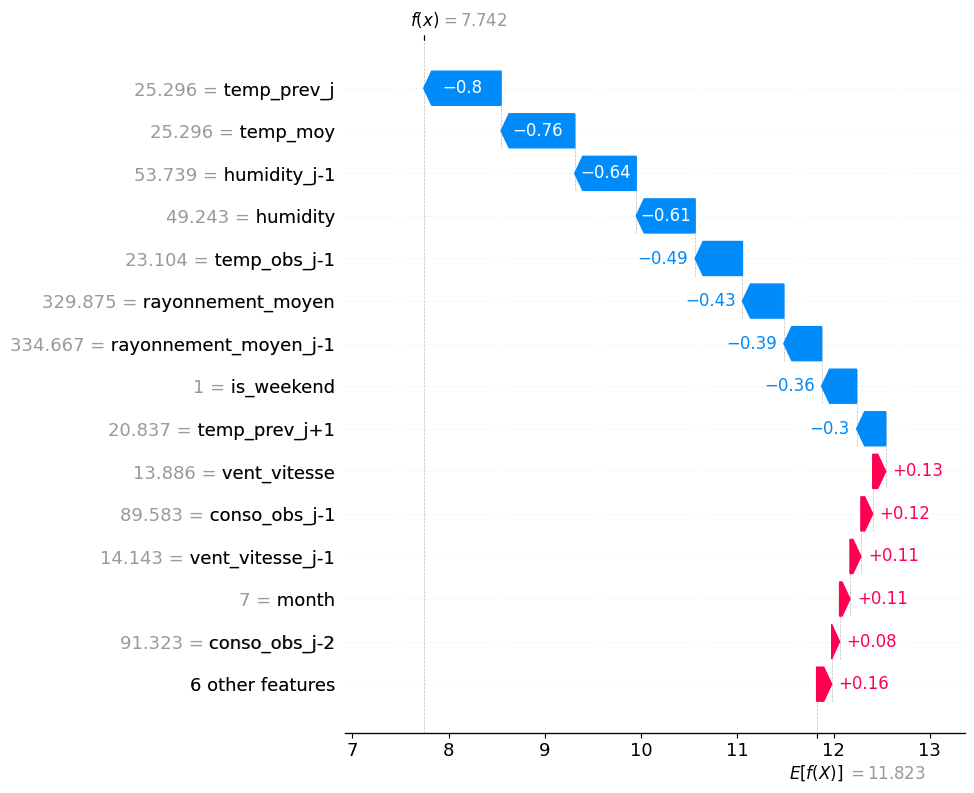

In [10]:
# 1. On prépare l'explication pour une anomalie spécifique
# On utilise l'Explainer moderne qui est plus compatible
explainer = shap.Explainer(model_if, train_clean)
shap_values = explainer(test_clean[features_cols])

# 2. On sélectionne l'index d'une anomalie détectée (ex: la première)
anomalie_idx = test_clean[test_clean['is_anomaly'] == -1].index[0]
# On récupère sa position entière dans le tableau pour SHAP
loc_idx = test_clean.index.get_loc(anomalie_idx)

# 3. Affichage en "Waterfall" (Cascade)
# Ce graphique part de la 'base value' et ajoute/soustrait les contributions
plt.figure(figsize=(10, 8))
shap.plots.waterfall(shap_values[loc_idx], max_display=15)

## PARTIE 2 : Normalisation des données (Scaling) ##

Les modèles de Machine Learning (et particulièrement les réseaux de neurones ou SVR) sont sensibles à l'échelle des données.

    MinMaxScaler / StandardScaler : Transformation des valeurs pour les ramener dans un intervalle réduit (ex: [0,1]).

    Objectif : Éviter que la variable "Consommation" (en centaines de MW) n'écrase par exemple la variable "Température" (en dizaines de degrés).

In [11]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. Normalisation
scaler_uni = MinMaxScaler(feature_range=(0, 1))
scaler_multi_x = MinMaxScaler(feature_range=(0, 1))
scaler_multi_y = MinMaxScaler(feature_range=(0, 1))




Nous allons maintenant créer les séquences qui serviront au LSTM

In [12]:

# Sélection des colonnes pour le modèle
features = [
    'conso_obs_j-1','conso_obs_j-2', 'conso_obs_j-7', 
    'temp_moy',   'humidity',  'vent_vitesse', 'rayonnement_moyen',
    'temp_obs_j-1',  'humidity_j-1', 'rayonnement_moyen_j-1', 'rayonnement_moyen_j-1','vent_vitesse_j-1',
    'temp_prev_j',  'temp_prev_j+1',
    'day_of_week','month','is_weekend','is_holiday','is_holiday_prev','is_holiday_next'
]
target = 'consommation'

X_train_multi = dataset_train_enriched[features].values
y_train_multi = dataset_train_enriched[target].values

X_test_multi = dataset_test_enriched[features].values
y_test_multi = dataset_test_enriched[target].values

X_train_multi_scaled = scaler_multi_x.fit_transform(X_train_multi)
X_test_multi_scaled = scaler_multi_x.transform(X_test_multi)
y_train_multi_scaled = scaler_multi_y.fit_transform(y_train_multi.reshape(-1, 1))
y_test_multi_scaled = scaler_multi_y.transform(y_test_multi.reshape(-1, 1))




def create_sequences_for_multivariate(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        # On prend une fenêtre de 'window_size' jours pour X
        X_seq.append(X[i-window_size:i])
        # La cible est la valeur de y juste après cette fenêtre
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Configuration de la fenêtre : on regarde les 7 derniers jours
window_size = 30 

X_train_multi_scaled_seq, y_train_multi_scaled_seq = create_sequences_for_multivariate(X_train_multi_scaled, y_train_multi_scaled, window_size)
X_test_multi_scaled_seq, y_test_multi_scaled_seq = create_sequences_for_multivariate(X_test_multi_scaled, y_test_multi_scaled, window_size)


print(f"Forme de dataset_train : {dataset_train.shape}")
print(f"Forme de dataset_test : {dataset_test.shape}") 

print(f"Forme de X_train_scaled_multi : {X_train_multi.shape}")
print(f"Forme de y_train_scaled_multi : {y_train_multi.shape}")


print(f"Forme de X_train_multi : {X_train_multi.shape}")
print(f"Forme de y_train_multi : {y_train_multi.shape}") 
print(f"Forme de X_test_multi : {X_test_multi.shape}")
print(f"Forme de y_test_multi : {y_test_multi.shape}") 

print(f"Forme de X_train_multi_scaled_seq : {X_train_multi_scaled_seq.shape}") 

Forme de dataset_train : (1820, 14)
Forme de dataset_test : (364, 14)
Forme de X_train_scaled_multi : (1820, 20)
Forme de y_train_scaled_multi : (1820,)
Forme de X_train_multi : (1820, 20)
Forme de y_train_multi : (1820,)
Forme de X_test_multi : (364, 20)
Forme de y_test_multi : (364,)
Forme de X_train_multi_scaled_seq : (1790, 30, 20)


## Partie 3 : création et entrainement du modèle ##

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Initialisation du modèle
model_lstm_multi = Sequential([
   
    # input_shape = (nb_pas_de_temps, nb_features)
    LSTM(50, activation='relu', input_shape=(window_size, X_train_multi_scaled_seq.shape[2]), return_sequences=False),
    
    
    # Dropout pour éviter le sur-apprentissage (overfitting)
    Dropout(0.2),
    
    # Couche Dense intermédiaire pour affiner les patterns
    Dense(32, activation='relu'),
    
    # Couche de sortie : 1 neurone pour la prédiction finale (valeur continue)
    Dense(1)
])

# Compilation
model_lstm_multi.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
# 3. Entraînement
# epochs : nombre de passages sur les données
# batch_size : nombre d'échantillons traités avant la mise à jour des poids
history = model_lstm_multi.fit(
    #X_train_multi_scaled_seq[:,:,0], y_train_multi_scaled_seq, 
    X_train_multi_scaled_seq,y_train_multi_scaled_seq,
    epochs=1000, 
    batch_size=32, 
    validation_split=0.1, # On garde 10% pour valider pendant l'entraînement
    callbacks=[early_stop],
    verbose=1
)



Epoch 1/1000


c:\Code_ML\Code\Atelier Time Series\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0199 - val_loss: 0.0071
Epoch 2/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - val_loss: 0.0064
Epoch 3/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - val_loss: 0.0054
Epoch 4/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 5/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0047
Epoch 6/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0050
Epoch 7/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0047
Epoch 8/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0036
Epoch 9/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0034
Epoch 10/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0030
Epoch 11/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0030
Epoch 12/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.00

In [14]:
# 1. Faire les prédictions sur le jeu de test
predictions_scaled = model_lstm_multi.predict(X_test_multi_scaled_seq)

# 2. Inverser la normalisation pour les prédictions et pour les vraies valeurs
y_pred = scaler_multi_y.inverse_transform(predictions_scaled)
y_actual = scaler_multi_y.inverse_transform(y_test_multi_scaled_seq)



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


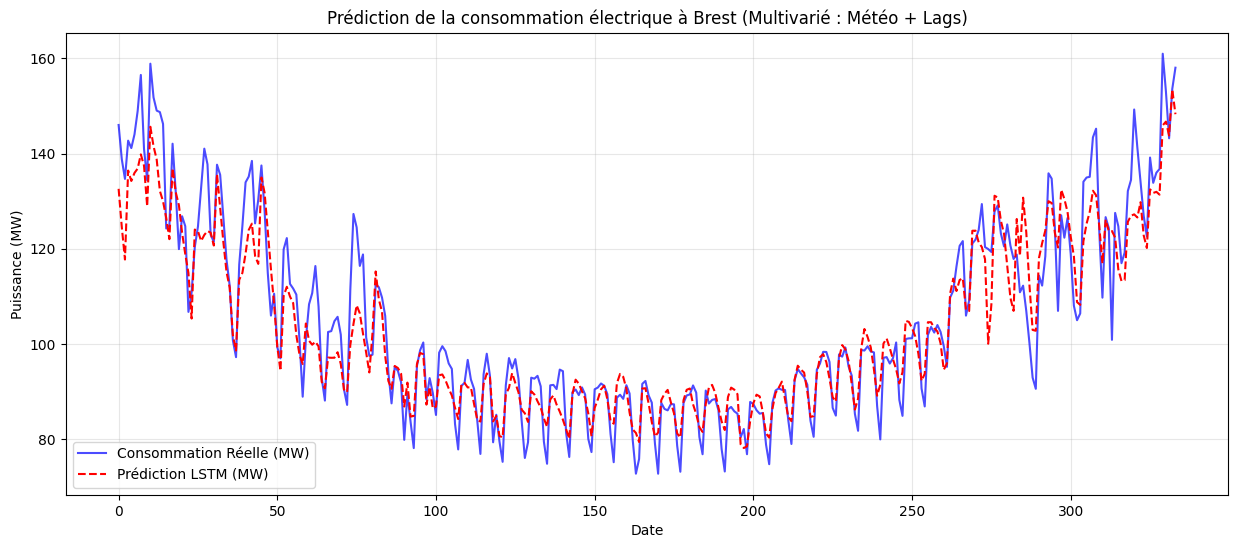

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(y_actual, label='Consommation Réelle (MW)', color='blue', alpha=0.7)
plt.plot(y_pred, label='Prédiction LSTM (MW)', color='red', linestyle='--')

plt.title('Prédiction de la consommation électrique à Brest (Multivarié : Météo + Lags)')
plt.xlabel('Date')
plt.ylabel('Puissance (MW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. MAE : Mean Absolute Error (Erreur Absolue Moyenne)
mae = mean_absolute_error(y_actual, y_pred)

# 2. RMSE : Root Mean Squared Error (Erreur Quadratique Moyenne)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))

# 3. MAPE : Mean Absolute Percentage Error (Erreur en Pourcentage)
mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100

print(f"📊 Performances du modèle LSTM :")
print(f"MAE  : {mae:.2f} MW")
print(f"RMSE : {rmse:.2f} MW")
print(f"MAPE : {mape:.2f} %")

📊 Performances du modèle LSTM :
MAE  : 4.96 MW
RMSE : 6.69 MW
MAPE : 4.58 %


## Explicabilité quantitative ##

### Explicabilit? de la d?tection d'anomalies (LSTM)

- Une anomalie est d?tect?e quand l'?cart `|y_r?el - y_pr?dit|` d?passe un seuil (par ex. un quantile des r?sidus calcul?s sur le train).
- SHAP permet d'expliquer **pourquoi** le mod?le a produit une pr?diction ?lev?e ou faible : chaque variable (et chaque pas de temps) re?oit une contribution vers la sortie.
- Le `background` repr?sente des s?quences normales ; SHAP compare l'exemple ? cette r?f?rence.
- On agr?ge ensuite les contributions sur les pas de temps pour obtenir une importance globale par variable, puis on repasse en MW.


Forme du background : (150, 30, 20)


Using 150 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Anomalie cible: 2025-07-12 00:00:00+00:00 | consommation reelle IF: 79.75 MW
Position brute: 192 | position sequence LSTM: 162


100%|██████████| 1/1 [00:25<00:00, 25.08s/it]


y_test min reel: 72.73 MW
base_value_mw: 106.25 MW | predicted_mw: 80.73 MW


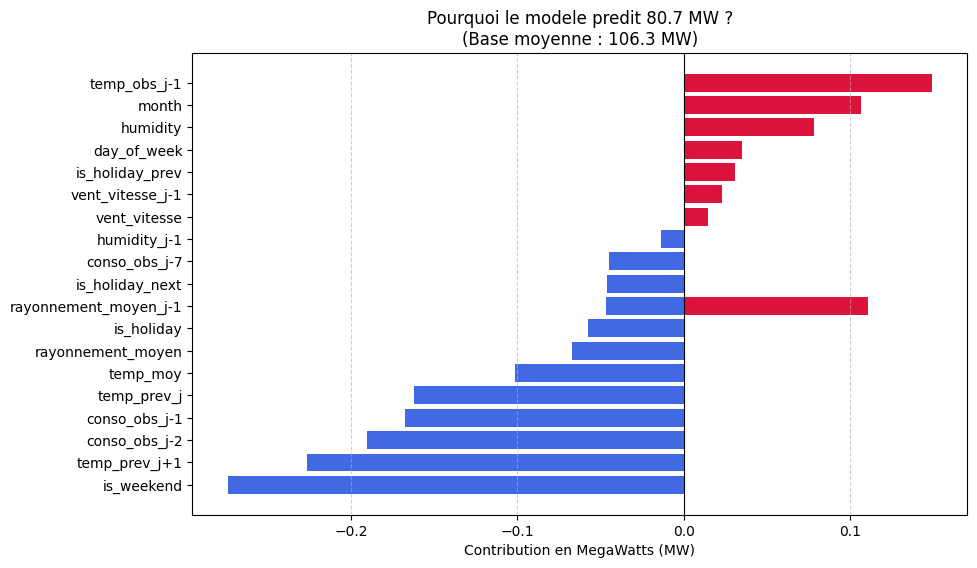

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

def to_numpy(x):
    if isinstance(x, tf.data.Dataset):
        # Empile les batches (X ou (X,y)) en un seul tableau
        xs = []
        for batch in x:
            xb = batch[0] if isinstance(batch, (tuple, list)) else batch
            xs.append(xb.numpy())
        return np.concatenate(xs, axis=0)
    return x.values if hasattr(x, 'values') else np.asarray(x)

# 1. Background de sequences normales (echantillon du train)
X_train_np = to_numpy(X_train_multi_scaled_seq)
X_test_np = to_numpy(X_test_multi_scaled_seq)

n_samples = 150 #X_train_np.shape[0]
rng = np.random.default_rng(42)
indices = rng.choice(X_train_np.shape[0], n_samples, replace=False)
background = X_train_np[indices]
print(f"Forme du background : {background.shape}")  # (n_samples, n_steps, n_features)


# 2. Explainer agnostique TF/Keras
# On aplatit les sequences pour le KernelExplainer
n_steps = X_train_np.shape[1]
n_features = X_train_np.shape[2]

def predict_flat(x_flat):
    x_seq = x_flat.reshape((-1, n_steps, n_features))
    return model_lstm_multi.predict(x_seq, verbose=0)

background_flat = background.reshape((background.shape[0], -1))
explainer = shap.KernelExplainer(predict_flat, background_flat)


# 3. Selection  de la 1ere anomalie trouvée par la méthode de Isolation Forest
anomalies_if = test_clean[test_clean['is_anomaly'] == -1]
target_anomaly_idx = anomalies_if.index[0]
target_anomaly_mw = float(anomalies_if.iloc[0]['consommation'])

# Pour chercher l'anomalie dans les séquences multivariée, on va passer par l'index temporel, puis décaler de window_size pour avoir la séquence
if target_anomaly_idx not in dataset_test_enriched.index:
    raise ValueError("L'index de l'anomalie n'existe pas dans dataset_test_enriched.")

raw_pos = dataset_test_enriched.index.get_loc(target_anomaly_idx)
loc_idx = raw_pos - window_size
if loc_idx < 0 or loc_idx >= X_test_np.shape[0]:
    raise ValueError(
        f"Index sequence hors bornes: raw_pos={raw_pos}, window_size={window_size}, loc_idx={loc_idx}."
    )

sample = X_test_np[loc_idx:loc_idx+1]
sample_flat = sample.reshape((1, -1))
n_flat = sample_flat.shape[1]

print(f"Anomalie cible: {target_anomaly_idx} | consommation reelle IF: {target_anomaly_mw:.2f} MW")
print(f"Position brute: {raw_pos} | position sequence LSTM: {loc_idx}")

# 4. explication de l'échantillon décrivant l'anomalie
shap_values = explainer.shap_values(
    sample_flat,
    nsamples=max(2 * n_flat, 200),
    l1_reg=0
)
if isinstance(shap_values, list):
    shap_values = shap_values[0]  

# 5. Mise en forme des SHAP values
shap_values = shap_values.reshape((1, n_steps, n_features))
shap_aggregated = shap_values.mean(axis=1).ravel()


expected_value = explainer.expected_value
if isinstance(expected_value, (list, tuple, np.ndarray)):
    expected_value = np.array(expected_value).ravel()[0]

# 6. récupération de la prédiction du LSTM
pred_scaled = float(model_lstm_multi.predict(sample, verbose=0).ravel()[0])

# Dénormalisation
base_value_mw = scaler_multi_y.inverse_transform([[expected_value]])[0, 0]
predicted_mw = scaler_multi_y.inverse_transform([[pred_scaled]])[0, 0]

# 7. Conversion des contributions SHAP en MW
coef_mw_per_scaled = (
    scaler_multi_y.inverse_transform([[1.0]])[0, 0]
    - scaler_multi_y.inverse_transform([[0.0]])[0, 0]
)
shap_mw = shap_aggregated * coef_mw_per_scaled


print(f"y_test min reel: {y_actual.min():.2f} MW")
print(f"base_value_mw: {base_value_mw:.2f} MW | predicted_mw: {predicted_mw:.2f} MW")


impact_df = pd.DataFrame({
    'Feature': features,
    'Impact_MW': shap_mw
}).sort_values(by='Impact_MW')

plt.figure(figsize=(10, 6))
colors = ['crimson' if x > 0 else 'royalblue' for x in impact_df['Impact_MW']]
plt.barh(impact_df['Feature'], impact_df['Impact_MW'], color=colors)
plt.axvline(0, color='black', linewidth=0.8)
plt.title(
    f"Pourquoi le modele predit {predicted_mw:.1f} MW ?\n"
    f"(Base moyenne : {base_value_mw:.1f} MW)"
)
plt.xlabel('Contribution en MegaWatts (MW)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()




Lors du 2025-07-12, la consommation réelle est 79.75 MW et le LSTM prédit 80.73 MW.
<br><br>
Le graphique SHAP s’interprète donc comme la décomposition des facteurs qui ont poussé la prédiction vers un niveau bas, ce qui est ici une bonne approximation des facteurs de la valeur réelle.
<br>
En parallèle, l’Isolation Forest classe ce point en anomalie car la combinaison des variables est rare par rapport au comportement habituel, même si elle reste explicable par le modèle de régression.
<br><br>
Conclusion : cette anomalie au sens “atypique”, mais pas au sens “incompréhensible”, puisque la baisse est bien capturée par le LSTM et cohérente avec les variables explicatives.